In [62]:
#importing

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
from scipy.optimize import curve_fit
import os

os.chdir('/Users/quinnmackay/Documents/GitHub/BICC/Data Storage/NGRIP/Density files')

#JP Legacy GRIP Shallow Core
grip1 = pd.read_csv('/Users/quinnmackay/Documents/GitHub/BICC/Data Storage/GRIP/GRIP1991shallow_density.txt',skiprows=6, header=None)
grip1.rename(columns={0: 'depth'}, inplace=True)
grip1.rename(columns={1: 'density'}, inplace=True)

#Jakob Spline Fit
ngrip1 = pd.read_csv('ng1mbp01.txt',skiprows=26, sep=r'\s+')
ngrip1.rename(columns={'DEPTH(m)': 'depth'}, inplace=True)
ngrip1.rename(columns={'Density': 'density'}, inplace=True)

#NGRIP1 Main Core
ngrip2 = pd.read_excel('NG96DEN.xls',skiprows=6, usecols=[3,6])
ngrip2.rename(columns={'Depth at bottom of bag (m)': 'depth'}, inplace=True)
ngrip2.rename(columns={'Density of bag (kg/m3)': 'density'}, inplace=True)

#2001 Shallow Core
ngrip3 = pd.read_csv('NGRIP_2001_S5_density.txt', skiprows=2, delimiter='\t')

#S4 from Dr. Kawamura
ngrip4 = pd.read_excel('firn data NGRIP2001/NGRPdens.xls', sheet_name=0, skiprows=5, header=None, usecols=[0,5])
ngrip4.rename(columns={0: 'depth'}, inplace=True)
ngrip4.rename(columns={5: 'density'}, inplace=True)

#S5 from Dr. Kawamura
ngrip5 = pd.read_excel('firn data NGRIP2001/NGRPdens.xls', sheet_name=1, skiprows=4, header=None, usecols=[0,5])
ngrip5.rename(columns={0: 'depth'}, inplace=True)
ngrip5.rename(columns={5: 'density'}, inplace=True)

#Kenji S2? Using MEAN depth
ngrip6 = pd.read_excel('NG97S2Density.xlsx', sheet_name=0, skiprows=2, usecols=[3,11], header=None)
ngrip6.rename(columns={3: 'depth'}, inplace=True)
ngrip6.rename(columns={11: 'density'}, inplace=True)
ngrip6

/opt/miniconda3/envs/bicc/lib/python3.13/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


,depth,density
0,1.79000,0.346096
1,2.42500,0.345778
2,2.90650,0.384213
3,3.26650,0.367351
4,3.72150,0.372722
...,...,...
244,138.08300,0.895170
245,138.23100,0.880701
246,138.43275,0.891083
247,138.61475,0.888203


Text(0, 0.5, 'Relative Density')

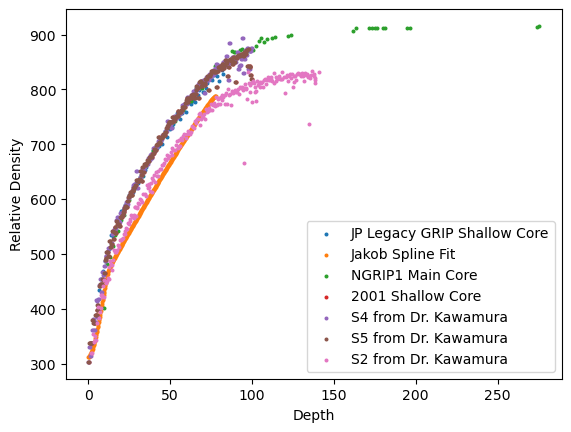

In [63]:
#creating plot

ice_dens = 921
size=3.5

plt.scatter(grip1['depth'], grip1['density'], label="JP Legacy GRIP Shallow Core", s=size)
plt.scatter(ngrip1['depth'], ngrip1['density']*ice_dens, label='Jakob Spline Fit', s=size)
plt.scatter(ngrip2['depth'], ngrip2['density'], label='NGRIP1 Main Core', s=size)
plt.scatter(ngrip3['depth'], ngrip3['density'], label='2001 Shallow Core', s=size)
plt.scatter(ngrip4['depth'], ngrip4['density'], label='S4 from Dr. Kawamura', s=size)
plt.scatter(ngrip5['depth'], ngrip5['density'], label='S5 from Dr. Kawamura', s=size)
plt.scatter(ngrip6['depth'], ngrip6['density']*ice_dens, label='S2 from Dr. Kawamura', s=size)

plt.legend()
plt.xlabel('Depth')
plt.ylabel('Relative Density')
#plt.xlim(25,40)
#plt.ylim(0.3,0.8)

In [64]:
#manually trim positive outliers

ngrip4 = pd.read_excel('firn data NGRIP2001/NGRPdens.xls', sheet_name=0, skiprows=5, header=None, usecols=[0,5])
ngrip4.rename(columns={0: 'depth'}, inplace=True)
ngrip4.rename(columns={5: 'density'}, inplace=True)

indexes = [312,313,342,343,106,107]
ngrip4['density'][indexes] = np.nan

ngrip4 = ngrip4.dropna(subset=['density'])
ngrip4 = ngrip4.reset_index(drop=True)

/var/folders/cd/1mh45k3j19g5g_kxkz_17xvc0000gn/T/ipykernel_1297/2812083537.py:8: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ngrip4['density'][indexes] = np.nan


In [65]:
#let's go by 0.2 at a time and filter out low data by a 5 density constraint

#0.2 spacing
intervals = np.arange(0,125.2+0.2,1)

dfs = [grip1, ngrip2, ngrip3, ngrip4, ngrip5]
combined_data = pd.concat(dfs, ignore_index=True)

#organize
combined_data = combined_data.sort_values(by='depth', ascending=True)

for i in range(len(intervals)):
    if i == 0:
        continue
    mask = (combined_data['depth'] < intervals[i]) & (combined_data['depth'] >= intervals[i - 1])
    maximum_val = np.max(combined_data[mask]['density'])
    if pd.isna(maximum_val):
        continue
    minimum_allowed = maximum_val - 0.0001

    combined_mask = mask & (combined_data['density'] < minimum_allowed)
    combined_data.loc[combined_mask, 'density'] = np.nan

    combined_data = combined_data.dropna(subset=['density'])

(0.0, 100.0)

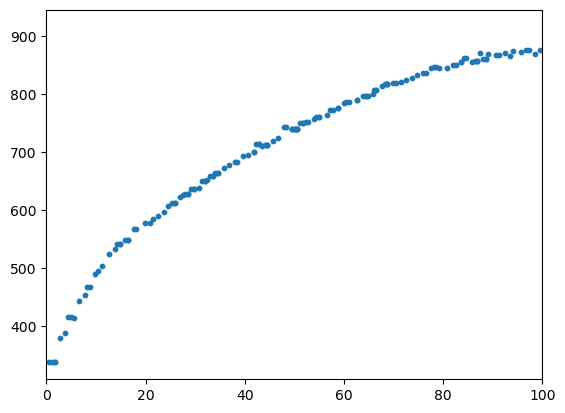

In [66]:
plt.scatter(combined_data['depth'], combined_data['density'], s=10)
plt.xlim(0,100)

In [67]:
#sort and average same depths
combined_data.reset_index(drop=True, inplace=True)
averaged_point_data = combined_data.groupby('depth', as_index=False).mean()

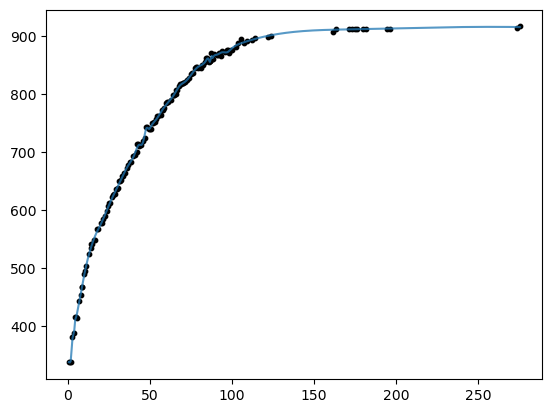

In [68]:
# spline fit a smooth curve that follows the data, but allows for a small amount of error
spline = UnivariateSpline(averaged_point_data['depth'], averaged_point_data['density'], s=1000)

z_smooth = np.linspace(combined_data['depth'].min(), combined_data['depth'].max(), 500)
rho_smooth = spline(z_smooth)

plt.plot(z_smooth, rho_smooth, alpha=0.75)
plt.scatter(averaged_point_data['depth'], averaged_point_data['density'], s=10, color='black', label='Data')
